In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

D:\ForeignExchange\foreignexchange\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\ForeignExchange\foreignexchange\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\ForeignExchange\foreignexchange\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#reading dataset
exchange_data = pd.read_csv('data/USDNGN3.csv')
exchange_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,12/1/2003,140.000000,140.000000,140.000000,140.0,140.0,0
1,12/2/2003,138.479996,138.479996,138.479996,140.0,140.0,0
2,12/3/2003,135.850006,135.850006,135.850006,140.0,140.0,0
3,12/4/2003,135.880005,140.000000,135.880005,140.0,140.0,0
4,12/5/2003,135.820007,138.500000,135.820007,138.5,138.5,0


In [3]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ngn_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [4]:
#checking first few records of the dataset
ngn_exchange_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,140.000000,140.000000,140.000000,140.0,140.0,0
2003-12-02,138.479996,138.479996,138.479996,140.0,140.0,0
2003-12-03,135.850006,135.850006,135.850006,140.0,140.0,0
2003-12-04,135.880005,140.000000,135.880005,140.0,140.0,0
2003-12-05,135.820007,138.500000,135.820007,138.5,138.5,0


<AxesSubplot:xlabel='Date'>

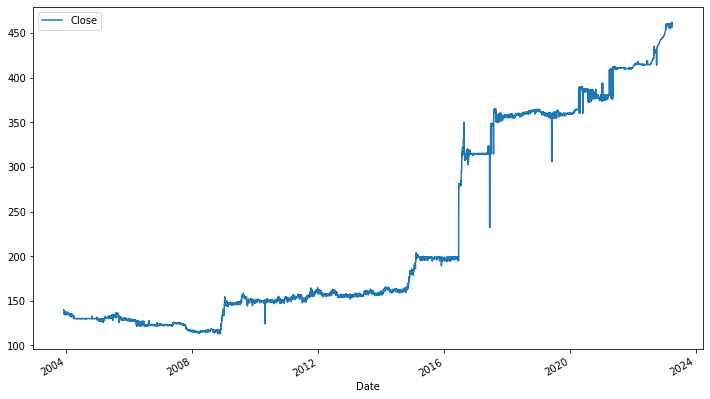

In [5]:

df = ngn_exchange_data[["Close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [6]:

diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("60 percent data = 2003 to %d"%(2003 + int(0.6*years)))

Total data: 19 years
60 percent data = 2003 to 2014


In [7]:
df.describe()

,Close
count,5035.000000
mean,227.422156
std,111.592091
min,112.910004
25%,135.400002
50%,159.600006
75%,358.000000
max,462.000000


D:\ForeignExchange\foreignexchange\lib\site-packages\IPython\core\interactiveshell.py:3135: UserWarning: Parsing '16-07-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


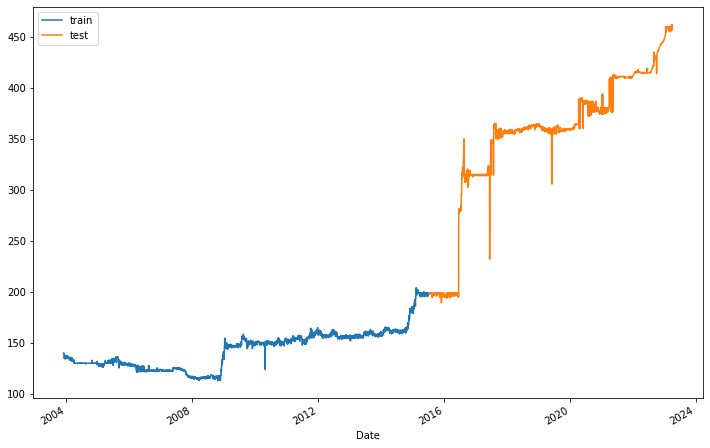

In [8]:
split_date = pd.Timestamp('16-07-2015')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [11]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [12]:
X_train.shape

(3020, 1)

In [13]:
X_test.shape

(2014, 1)

In [20]:
x_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [25]:
from keras.layers import GRU
K.clear_session()
model = Sequential()
model.add(GRU(7, input_shape=(1, X_train.shape[1]), activation= 'relu', kernel_initializer='lecun_uniform', return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7)                 210       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model = model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
3020/3020 [==============================] - 42s 12ms/step - loss: 0.0065 - rmse: 0.0809
Epoch 2/100
3020/3020 [==============================] - 36s 12ms/step - loss: 0.0062 - rmse: 0.0788
Epoch 3/100
3020/3020 [==============================] - 36s 12ms/step - loss: 0.0063 - rmse: 0.0795
Epoch 4/100
3020/3020 [==============================] - 42s 14ms/step - loss: 0.0064 - rmse: 0.0798
Epoch 5/100
3020/3020 [==============================] - 39s 13ms/step - loss: 0.0064 - rmse: 0.0798
Epoch 6/100
3020/3020 [==============================] - 35s 12ms/step - loss: 0.0063 - rmse: 0.0796
Epoch 7/100
3020/3020 [==============================] - 34s 11ms/step - loss: 0.0064 - rmse: 0.0797
Epoch 8/100
3020/3020 [==============================] - 31s 10ms/step - loss: 0.0064 - rmse: 0.0798
Epoch 9/100
3020/3020 [==============================] - 31s 10ms/step - loss: 0.0064 - rmse: 0.0799
Epoch 10/100
3020/3020 [==============================] - 35s 12ms/step - loss: 0.0064 - rm

In [41]:
#GRU PREDICTION

y_pred_test = model.predict(x_test)
y_train_pred = model.predict(x_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

95/95 [==============================] - 1s 9ms/step
The R2 score on the Train set is:	0.848
The  MAE on the Train set is:	0.323
The  RMSE on the Train set is:	0.390
The Adjusted R2 score on the Train set is:	0.848

The R2 score on the Test set is:	0.994
The Adjusted R2 score on the Test set is:	0.994
The  MAE on the Test set is:	0.101
The  RMSE on the Test set is:	0.278


In [28]:
inv_yhat = sc.inverse_transform(y_pred_test)

inv_yhat

array([[198.94348],
       [198.84413],
       [197.47578],
       ...,
       [460.35382],
       [459.36993],
       [458.21893]], dtype=float32)

In [29]:
inv_ytest = sc.inverse_transform(y_test)

inv_ytest

array([[198.800003],
       [197.419998],
       [198.899994],
       ...,
       [461.      ],
       [459.829987],
       [459.809998]])

In [30]:
from sklearn. metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test)

0.07712459248028142

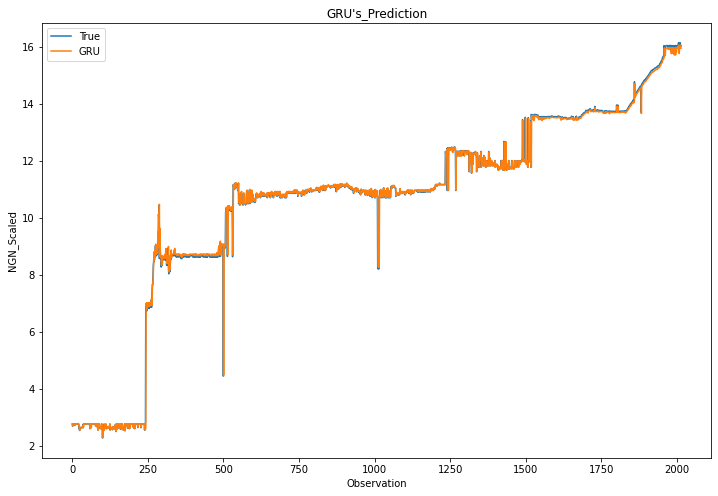

In [31]:
#LSTM PREDICTION PLOT

plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('NGN_Scaled')
plt.legend()
plt.show()

In [32]:
test_mse = metrics.mean_squared_error(inv_ytest, inv_yhat)
rmse_test = np.sqrt(test_mse)


print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(inv_ytest, inv_yhat)))
r2_test = r2_score(inv_ytest, inv_yhat)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(inv_ytest, inv_yhat)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Test set is:	0.994
The Adjusted R2 score on the Test set is:	0.994
The  MAE on the Test set is:	1.982
The  RMSE on the Test set is:	5.465


In [33]:
test.head()

,Close
Date,
2015-07-16,198.899994
2015-07-17,198.800003
2015-07-20,197.419998
2015-07-21,198.899994
2015-07-22,198.949997


In [34]:
col1 = pd.DataFrame(inv_ytest, columns=['Close'])

col2 = pd.DataFrame(inv_yhat, columns=['GRU_prediction'])

col3 = pd.DataFrame(history_model.history['rmse'], columns=['RMSE'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_csv('Prediction_USD_NGN_GRU.xlsx')

In [35]:
results.head()

,Close,GRU_prediction,RMSE
0,198.800003,198.943481,0.080926
1,197.419998,198.844131,0.078809
2,198.899994,197.475784,0.079456
3,198.949997,198.943481,0.079764
4,198.850006,198.993195,0.079818


In [36]:
test.reset_index(level=0, inplace=True)
test.head()

,Date,Close
0,2015-07-16,198.899994
1,2015-07-17,198.800003
2,2015-07-20,197.419998
3,2015-07-21,198.899994
4,2015-07-22,198.949997


In [37]:
dfinal = test.merge(results, how='inner', left_on='Close', right_on='Close')

In [38]:
dfinal.drop_duplicates(subset="Date",inplace=True)


dfinal.head(2000)

,Date,Close,GRU_prediction,RMSE
0,2015-07-16,198.899994,197.475784,0.079456
22,2015-07-21,198.899994,197.475784,0.079456
44,2015-07-27,198.899994,197.475784,0.079456
66,2015-07-28,198.899994,197.475784,0.079456
88,2015-08-14,198.899994,197.475784,0.079456
...,...,...,...,...
53682,2023-04-05,462.000000,459.369934,NaN
53684,2023-03-31,459.000000,454.451935,NaN
53685,2023-04-03,459.839996,457.402466,NaN
53686,2023-04-04,459.829987,458.228790,NaN


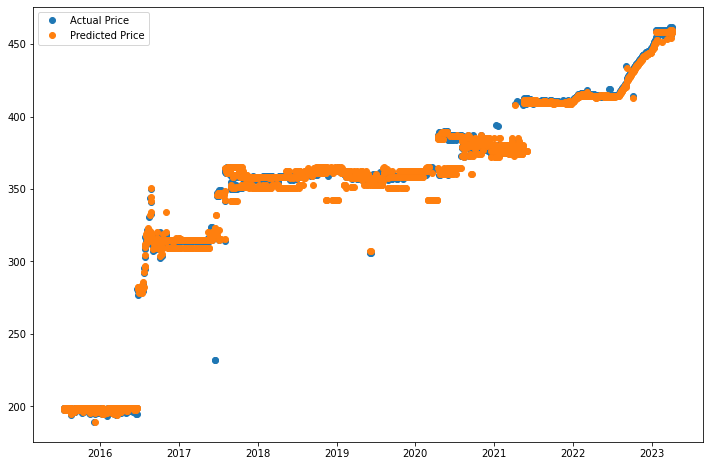

In [39]:
plt.figure(figsize=(12,8))
price_date = dfinal['Date']
price_true = dfinal['Close']
price_pred = dfinal['GRU_prediction']
plt.plot_date(price_date, price_true,label='Actual Price')
plt.plot_date(price_date, price_pred,label='Predicted Price')
plt.legend()
plt.show()

In [40]:
dfinal.describe()

,Close,GRU_prediction,RMSE
count,1985.000000,1985.000000,73.000000
mean,351.547069,350.063293,0.079840
std,67.970868,67.387535,0.000494
min,189.220001,189.484116,0.078809
25%,322.000000,320.216827,0.079456
50%,360.000000,360.807312,0.079764
75%,389.510010,386.761353,0.079818
max,462.000000,459.369934,0.080926


In [42]:
#SAVING TRAINED MODEL

from tensorflow.keras.models import save_model
save_model(model, 'GRUmodel.h5')

In [43]:
model.save('GRUmodel')

INFO:tensorflow:Assets written to: GRUmodel\assets


In [44]:
# LOADING THE TRAINED MODEL

from tensorflow.keras.models import load_model
model = load_model('GRUmodel.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7)                 210       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________
